In [1]:
import numpy as np
import random
import torch
import os
import spacy
from torchtext.vocab import GloVe, FastText
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

positive_set = open("Train.pos", "r", encoding="latin-1").read()
negative_set = open("Train.neg", "r", encoding="latin-1").read()
test_set = open("TestData", "r", encoding="latin-1").read()

pos_set = positive_set.split("\n")[:-1]
neg_set = negative_set.split("\n")[:-1]
test_set = test_set.split("\n")[:-1]

/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Downloads GloVe and FastText
global_vectors = GloVe(name='840B', dim=300)
fasttext = FastText(language="en")

# ----------- Text Preprocessing -----------
nlp = spacy.load("en_core_web_md")

data_set = []

vocabulary = {}

chars_to_remove = ['--', '`', '~', '<', '>', '*', '{', '}', '^', '=', '_', '[', ']', '|', '- ', '.', ',']

for i, v in enumerate(pos_set):

    # Removing punctuations
    for chars in chars_to_remove:
        v = v.replace(chars, " ", -1)

    sentence = torch.zeros(600)
    n = 0
    for token in nlp(v): 

        sentence[:300] += global_vectors.get_vecs_by_tokens(token.text, lower_case_backup=True)
        sentence[300:] += fasttext.get_vecs_by_tokens(token.text, lower_case_backup=True).squeeze(dim=0)
        n += 1

    # Taking mean
    sentence = sentence / n
    data_set.append((sentence, 1))

for i, v in enumerate(neg_set):
    
    # Removing punctuations
    for chars in chars_to_remove:
        v = v.replace(chars, " ", -1)

    sentence = torch.zeros(600)
    n = 0
    for token in nlp(v):

        sentence[:300] += global_vectors.get_vecs_by_tokens(token.text, lower_case_backup=True)
        sentence[300:] += fasttext.get_vecs_by_tokens(token.text, lower_case_backup=True).squeeze(dim=0)
        n += 1
    
    # Taking mean
    sentence = sentence / n
    data_set.append((sentence, 0))


In [11]:
def set_seed(seed = 42):
    '''
        For Reproducibility: Sets the seed of the entire notebook.
    '''

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    # Sets a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(1)

# Train-Valid split of 95-05
def split_indices(n, val_pct):

    # Determine size of Validation set
    n_val = int(val_pct * n)

    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

train_pos_indices, val_pos_indices = split_indices(len(pos_set), 0.05)
train_neg_indices, val_neg_indices = split_indices(len(neg_set), 0.05)

train_indices = np.concatenate((train_pos_indices, train_neg_indices+len(pos_set)-1))
val_indices = np.concatenate((val_pos_indices, val_neg_indices+len(pos_set)-1))


# ----------- Batching the data -----------
def collate_fn(instn):

    sentence = torch.zeros(len(instn), 600)

    for i, v in enumerate(instn):
        sentence[i] = v[0]

    labels = torch.Tensor([x[1] for x in instn])

    return (sentence, labels)


batch_size = 100

train_sampler   = SubsetRandomSampler(train_indices)
train_loader    = DataLoader(data_set, batch_size, sampler=train_sampler, collate_fn=collate_fn)

val_sampler     = SubsetRandomSampler(val_indices)
val_loader      = DataLoader(data_set, batch_size, sampler=val_sampler, collate_fn=collate_fn)


# ----------- Model -----------
class DAN(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(600, 1024)
        self.linear2 = nn.Linear(1024, 2048)
        self.linear3 = nn.Linear(2048, 512)
        self.linear4 = nn.Linear(512, 64)
        self.linear5 = nn.Linear(64, 1)

    def forward(self, Xb, tsne = False):
        x = self.linear1(Xb)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x) 
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        
        if tsne == True:
            return x
            
        x = F.relu(x)
        x = self.linear5(x)
        x = torch.sigmoid(x)
        return x

if torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")


model = DAN()
model.to(device)
opt_c = torch.optim.Adagrad(model.parameters(), lr = 0.001)
# loss_fn_c = F.cross_entropy - Tried Cross Entropy with log_softmax output function - gave similar results
loss_fn_c = F.binary_cross_entropy


# ----------- Main Training Loop -----------
max_epoch = 25

best_test_acc = 0
for ep in range(max_epoch):

    epoch_loss = 0

    model.train()

    for xb, yb in tqdm(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)

        y_hat = model(xb)

        loss = loss_fn_c(y_hat.squeeze(), yb)

        loss.backward()

        opt_c.step()

        opt_c.zero_grad()

        epoch_loss += loss

    print("Epoch: ", ep+1, " Training Loss: ", epoch_loss.item())


    #----------- Validation -----------

    val_labels = []
    val_pred = []

    model.eval()

    val_epoch_loss = 0

    for xb, yb in tqdm(val_loader):
        xb = xb.to(device)
        yb = yb.to(device)

        y_hat = model(xb)

        loss = loss_fn_c(y_hat.squeeze(), yb)

        val_epoch_loss += loss

        val_labels.extend(torch.round(yb).cpu().detach().numpy())
        val_pred.extend(y_hat.round().cpu().detach().numpy())

    print("Validation loss: ", val_epoch_loss.item())
    print("Validation accuracy: ", accuracy_score(val_labels, val_pred)*100)


    if ep > 15 and prev_val_loss - val_epoch_loss.item() > 0.05:
        print("Saving Model")
        torch.save(model.state_dict(), "best_model.pt")
    
    prev_val_loss = val_epoch_loss.item()
    

100%|██████████| 95/95 [00:01<00:00, 62.93it/s]


Epoch:  1  Training Loss:  52.01685333251953


100%|██████████| 5/5 [00:00<00:00, 84.47it/s]


Validation loss:  2.4496610164642334
Validation accuracy:  76.2


100%|██████████| 95/95 [00:00<00:00, 105.20it/s]


Epoch:  2  Training Loss:  44.84339904785156


100%|██████████| 5/5 [00:00<00:00, 174.00it/s]


Validation loss:  2.3759779930114746
Validation accuracy:  77.2


100%|██████████| 95/95 [00:00<00:00, 109.14it/s]


Epoch:  3  Training Loss:  43.23063278198242


100%|██████████| 5/5 [00:00<00:00, 164.92it/s]


Validation loss:  2.4103777408599854
Validation accuracy:  75.6


100%|██████████| 95/95 [00:01<00:00, 73.75it/s]


Epoch:  4  Training Loss:  42.3495979309082


100%|██████████| 5/5 [00:00<00:00, 261.69it/s]


Validation loss:  2.343848943710327
Validation accuracy:  77.0


100%|██████████| 95/95 [00:00<00:00, 100.27it/s]


Epoch:  5  Training Loss:  41.58976364135742


100%|██████████| 5/5 [00:00<00:00, 101.84it/s]


Validation loss:  2.3201351165771484
Validation accuracy:  76.8


100%|██████████| 95/95 [00:01<00:00, 48.65it/s]


Epoch:  6  Training Loss:  40.7598991394043


100%|██████████| 5/5 [00:00<00:00, 58.12it/s]


Validation loss:  2.378577470779419
Validation accuracy:  77.2


100%|██████████| 95/95 [00:01<00:00, 88.53it/s] 


Epoch:  7  Training Loss:  40.04454040527344


100%|██████████| 5/5 [00:00<00:00, 69.01it/s]


Validation loss:  2.3264691829681396
Validation accuracy:  76.8


100%|██████████| 95/95 [00:01<00:00, 77.30it/s] 


Epoch:  8  Training Loss:  39.2481803894043


100%|██████████| 5/5 [00:00<00:00, 67.38it/s]


Validation loss:  2.3136534690856934
Validation accuracy:  77.0


100%|██████████| 95/95 [00:00<00:00, 98.20it/s] 


Epoch:  9  Training Loss:  38.60802459716797


100%|██████████| 5/5 [00:00<00:00, 68.91it/s]


Validation loss:  2.3136160373687744
Validation accuracy:  76.8


100%|██████████| 95/95 [00:00<00:00, 95.01it/s] 


Epoch:  10  Training Loss:  37.7671012878418


100%|██████████| 5/5 [00:00<00:00, 92.45it/s]


Validation loss:  2.3162856101989746
Validation accuracy:  76.8


100%|██████████| 95/95 [00:00<00:00, 116.16it/s]


Epoch:  11  Training Loss:  37.089263916015625


100%|██████████| 5/5 [00:00<00:00, 110.33it/s]


Validation loss:  2.32411527633667
Validation accuracy:  76.8


100%|██████████| 95/95 [00:01<00:00, 87.48it/s] 


Epoch:  12  Training Loss:  36.3021125793457


100%|██████████| 5/5 [00:00<00:00, 155.08it/s]


Validation loss:  2.322065591812134
Validation accuracy:  77.2


100%|██████████| 95/95 [00:01<00:00, 75.91it/s]


Epoch:  13  Training Loss:  35.30214309692383


100%|██████████| 5/5 [00:00<00:00, 72.79it/s]


Validation loss:  2.34572696685791
Validation accuracy:  75.6


100%|██████████| 95/95 [00:00<00:00, 103.73it/s]


Epoch:  14  Training Loss:  34.155826568603516


100%|██████████| 5/5 [00:00<00:00, 92.19it/s]


Validation loss:  2.3674802780151367
Validation accuracy:  75.4


100%|██████████| 95/95 [00:01<00:00, 76.16it/s]


Epoch:  15  Training Loss:  33.44561767578125


100%|██████████| 5/5 [00:00<00:00, 114.25it/s]


Validation loss:  2.3790085315704346
Validation accuracy:  76.0


100%|██████████| 95/95 [00:01<00:00, 83.17it/s]


Epoch:  16  Training Loss:  32.43670654296875


100%|██████████| 5/5 [00:00<00:00, 41.28it/s]


Validation loss:  2.4079675674438477
Validation accuracy:  77.0


100%|██████████| 95/95 [00:01<00:00, 88.23it/s] 


Epoch:  17  Training Loss:  31.225675582885742


100%|██████████| 5/5 [00:00<00:00, 198.70it/s]


Validation loss:  2.4464755058288574
Validation accuracy:  76.2


100%|██████████| 95/95 [00:01<00:00, 88.92it/s]


Epoch:  18  Training Loss:  30.046119689941406


100%|██████████| 5/5 [00:00<00:00, 97.76it/s]


Validation loss:  2.451523780822754
Validation accuracy:  75.6


100%|██████████| 95/95 [00:01<00:00, 65.15it/s]


Epoch:  19  Training Loss:  28.97698402404785


100%|██████████| 5/5 [00:00<00:00, 38.80it/s]


Validation loss:  2.5168871879577637
Validation accuracy:  76.0


100%|██████████| 95/95 [00:01<00:00, 79.64it/s]


Epoch:  20  Training Loss:  27.98923110961914


100%|██████████| 5/5 [00:00<00:00, 82.96it/s]


Validation loss:  2.6956260204315186
Validation accuracy:  76.6


100%|██████████| 95/95 [00:00<00:00, 123.14it/s]


Epoch:  21  Training Loss:  26.736474990844727


100%|██████████| 5/5 [00:00<00:00, 85.58it/s]


Validation loss:  2.6207098960876465
Validation accuracy:  75.2
Saving Model


100%|██████████| 95/95 [00:00<00:00, 99.61it/s] 


Epoch:  22  Training Loss:  25.480976104736328


100%|██████████| 5/5 [00:00<00:00, 50.12it/s]


Validation loss:  2.7357184886932373
Validation accuracy:  76.4


100%|██████████| 95/95 [00:00<00:00, 109.91it/s]


Epoch:  23  Training Loss:  25.112550735473633


100%|██████████| 5/5 [00:00<00:00, 178.76it/s]


Validation loss:  2.647221326828003
Validation accuracy:  76.4
Saving Model


100%|██████████| 95/95 [00:01<00:00, 84.05it/s]


Epoch:  24  Training Loss:  23.227310180664062


100%|██████████| 5/5 [00:00<00:00, 60.23it/s]


Validation loss:  2.724771022796631
Validation accuracy:  74.4


100%|██████████| 95/95 [00:00<00:00, 116.28it/s]


Epoch:  25  Training Loss:  22.331491470336914


100%|██████████| 5/5 [00:00<00:00, 228.78it/s]

Validation loss:  2.790689706802368
Validation accuracy:  75.0


In [17]:
# ----------- Test Data Preprocessing -----------

data_set_test = []

for i, v in enumerate(test_set):

    for chars in chars_to_remove:
        v = v.replace(chars, " ", -1)

    sentence = torch.zeros(600)
    n = 0
    for token in nlp(v): 

        sentence[:300] += global_vectors.get_vecs_by_tokens(token.text, lower_case_backup=True)
        sentence[300:] += fasttext.get_vecs_by_tokens(token.text, lower_case_backup=True).squeeze(dim=0)

        n += 1
    sentence = sentence / n
    if i < 331:
        data_set_test.append((sentence, 1))
    else:
        data_set_test.append((sentence, 0))

test_loader    = DataLoader(data_set_test, batch_size, collate_fn=collate_fn)

classifier = DAN()
classifier.to(device)

# My original best model - best_model_overall.pt
# Current best model - best_model.pt, change it to best_model.pt in the following line.
classifier.load_state_dict(torch.load("best_model_overall.pt"))

# ----------- Testing -----------

test_labels = []
test_pred = []

test_loss = 0

classifier.eval()

for xb, yb in tqdm(test_loader):
    xb = xb.to(device)
    yb = yb.to(device)

    y_hat = classifier(xb)

    loss = loss_fn_c(y_hat.squeeze(), yb)

    test_loss += loss

    test_labels.extend(torch.round(yb).cpu().detach().numpy())
    test_pred.extend(y_hat.round().cpu().detach().numpy())

print("Test loss: ", test_loss.item())
print("Test accuracy: ", accuracy_score(test_labels, test_pred)*100)

100%|██████████| 7/7 [00:00<00:00, 53.33it/s]

Test loss:  3.092072010040283
Test accuracy:  82.02416918429003


/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


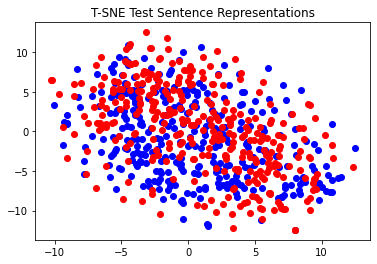

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

test_data = []
test_labels = []

for i in data_set_test:
    test_data.append(i[0].cpu().detach().numpy())
    test_labels.append(i[1])

tsne = TSNE(n_components=2)

out = tsne.fit_transform(test_data)

for i, v in enumerate(out):
    
    if test_labels[i] == 0:
        plt.scatter(v[0], v[1], c='r')    # Red for negative class
    else:
        plt.scatter(v[0], v[1], c='b')    # Blue for positive class
plt.title("T-SNE Test Sentence Representations")
plt.show()

100%|██████████| 7/7 [00:00<00:00, 85.63it/s]
/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


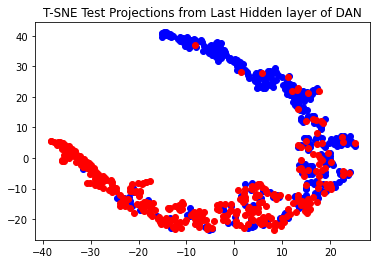

In [21]:
test_data = []
test_labels = []

for xb, yb in tqdm(test_loader):
    xb = xb.to("cuda:1")
    xb = classifier(xb, tsne=True)

    for i in range(len(xb)):
        test_data.append(xb[i].cpu().detach().numpy())
    test_labels.append(yb.cpu().detach().numpy())


tsne = TSNE(n_components=2)

out = tsne.fit_transform(test_data)

for i, v in enumerate(out):
    if test_labels[i//100][i%100] == 0:
        plt.scatter(v[0], v[1], c='r')
    else:
        plt.scatter(v[0], v[1], c='b')
plt.title("T-SNE Test Projections from Last Hidden layer of DAN")
plt.show()